In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

### Minimax Optimization Notebook

We consider problems of the form : 
$$
\max_{x \in X} \min_{y\in Y} f(x,y) ~~~~ (L)
$$
When the objective $f:X \times Y \rightarrow \mathbb{R}$ is of the form :
$$
f(x,y) = x^T A y,
$$
, where $A$ is full-rank, we say that it is **bilinear**. When the objective $f:X \times Y \rightarrow \mathbb{R}$ satisfies for fixed $x\in X$ and $\forall y \in Y$:
$$
f(x,y_1 \cdot \gamma + y_2 \cdot (1 - \gamma)) \geq \gamma f(x,y_1) \cdot  (1 - \gamma) f(x,y_2),
$$
and for fixed $y\in Y$ and $\forall x \in X$:
$$
f(x_1 \cdot \gamma + x_2 \cdot (1 - \gamma),y) \leq \gamma f(x_1,y) \cdot  (1 - \gamma) f(x_2,y),
$$
then we say it is **concave-convex**.

In [6]:
def plot_scalar_field(ax,fun,lims = [-3,3,-3,3], n=256, cmap = cm.hot):
    n = 256 
    x = jnp.linspace(lims[0], lims[1], n) 
    y = jnp.linspace(lims[2], lims[3], n) 
    X, Y = jnp.meshgrid(x, y) 
    Z = fun(X,Y)
    ax.pcolormesh(X, Y, Z, cmap = cmap) 
    ax.set_aspect('equal', 'box')

#### Minimal 2-d example

Let us define the function $f: \mathbb{R}^1 \times \mathbb{R}^1 \rightarrow \mathbb{R}$: 
$$
f(x,y) = xy,
$$
it is an extremely simple bilinear form where $A = [1]$. We will try to run and visualize our algorithms on it.

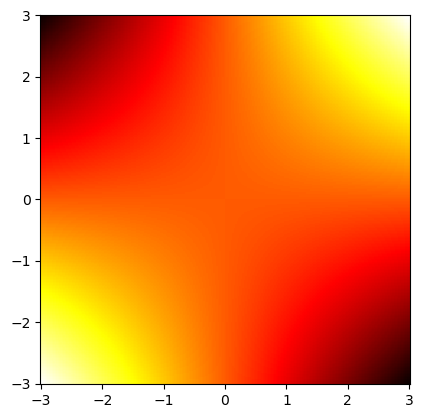

In [7]:
@jax.jit
def simple_2d_objective(x,y):
    return x * y
_, ax = plt.subplots(); plot_scalar_field(ax,simple_2d_objective); plt.show() # plot the function

#### Naive GDA implementation

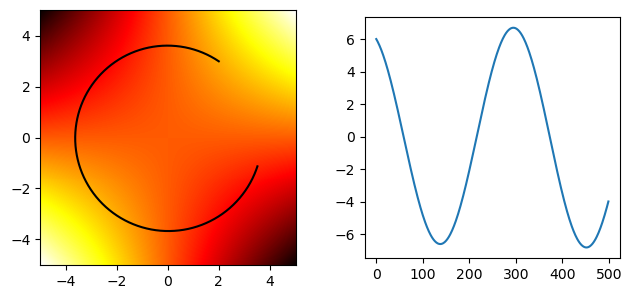

In [8]:
""" Implementing the algorithm """
def GDA_step(f,x,y,eta,tau):
    Dx = jax.grad(f,0)(x,y) # minimization parameter grad
    Dy = jax.grad(f,1)(x,y) # maximization parameter grad
    return x - eta*Dx, y + eta*tau*Dy

def GDA_solve(f,x,y,steps,eta,tau):
    xs = []; ys = []; fs = [];
    for _ in range(steps):
        xs += [x]; ys += [y]
        fs += [f(x,y)]
        x, y = GDA_step(f,x,y,eta,tau)
    xs = jnp.array(xs); ys = jnp.array(ys); fs = jnp.array(fs)
    return xs,ys,fs

""" Solving with GDA """
x = 2.; y = 3.;
xs,ys,fs = GDA_solve(simple_2d_objective,x,y,500,0.01,1.)

""" Nice little plot to see in all 
details how the algorithm miserably fails """
fig, ax = plt.subplots(1,2); plot_scalar_field(ax[0],simple_2d_objective,lims=[-5,5,-5,5]); ax[0].plot(xs,ys,color='k')
ax[1].plot(fs) ; ax[1].set_aspect(35); fig.tight_layout(); plt.show() # plot the function

#### Optimistic GDA implementation

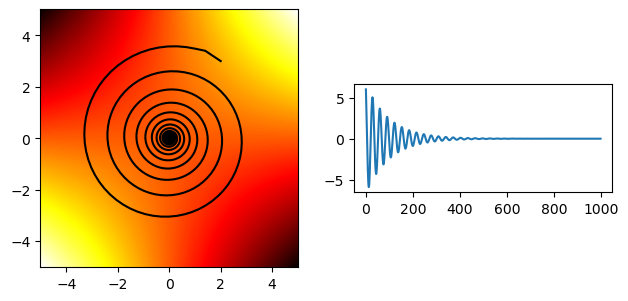

In [9]:
""" Implementing the algorithm """
def OGDA_step(f,x,y,prev_dx,prev_dy,eta,tau):
    Dx = jax.grad(f,0)(x,y) # minimization parameter grad
    Dy = jax.grad(f,1)(x,y) # maximization parameter grad
    return x - 2 * eta*Dx + eta*prev_dx, y + 2*eta*tau*Dy-eta*prev_dy, Dx, Dy

def OGDA_solve(f,x,y,steps,eta,tau):
    xs = []; ys = []; fs = []; prev_dx = 0; prev_dy = 0
    for _ in range(steps):
        xs += [x]; ys += [y]
        fs += [f(x,y)]
        x, y, prev_dx, prev_dy = OGDA_step(f,x,y,prev_dx,prev_dy,eta,tau)
    xs = jnp.array(xs); ys = jnp.array(ys); fs = jnp.array(fs)
    return xs,ys,fs

""" Solving with GDA """
x = 2.; y = 3.;
xs,ys,fs = OGDA_solve(simple_2d_objective,x,y,1000,0.1,1.)

""" Nice little plot to see in all 
details how the algorithm miserably fails """
fig, ax = plt.subplots(1,2); plot_scalar_field(ax[0],simple_2d_objective,lims=[-5,5,-5,5]); ax[0].plot(xs,ys,color='k')
ax[1].plot(fs) ; ax[1].set_aspect(35); fig.tight_layout(); plt.show() # plot the function

#### Extra Gradient GDA implementation

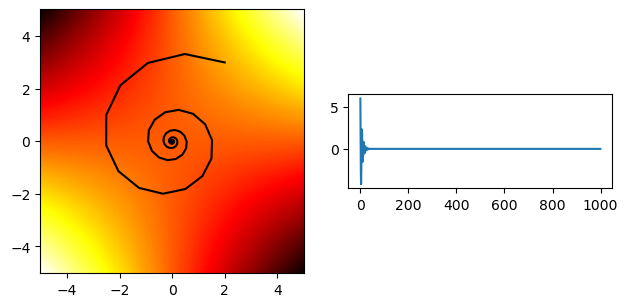

In [10]:
""" Implementing the algorithm """
def EGDA_step(f,x,y,eta,tau):
    Dx = jax.grad(f,0)(x,y) # minimization parameter grad
    Dy = jax.grad(f,1)(x,y) # maximization parameter grad
    EDx = jax.grad(f,0)(x - eta*Dx, y + eta*tau*Dy)
    EDy = jax.grad(f,1)(x - eta*Dx, y + eta*tau*Dy)
    return x - eta*EDx, y + eta*tau*EDy

def EGDA_solve(f,x,y,steps,eta,tau):
    xs = []; ys = []; fs = []
    for _ in range(steps):
        xs += [x]; ys += [y]
        fs += [f(x,y)]
        x, y = EGDA_step(f,x,y,eta,tau)
    xs = jnp.array(xs); ys = jnp.array(ys); fs = jnp.array(fs)
    return xs,ys,fs

""" Solving with GDA """
x = 2.; y = 3.;
xs,ys,fs = EGDA_solve(simple_2d_objective,x,y,1000,0.4,1.)

""" Nice little plot to see in all 
details how the algorithm miserably fails """
fig, ax = plt.subplots(1,2); plot_scalar_field(ax[0],simple_2d_objective,lims=[-5,5,-5,5]); ax[0].plot(xs,ys,color='k')
ax[1].plot(fs) ; ax[1].set_aspect(35); fig.tight_layout(); plt.show() # plot the function

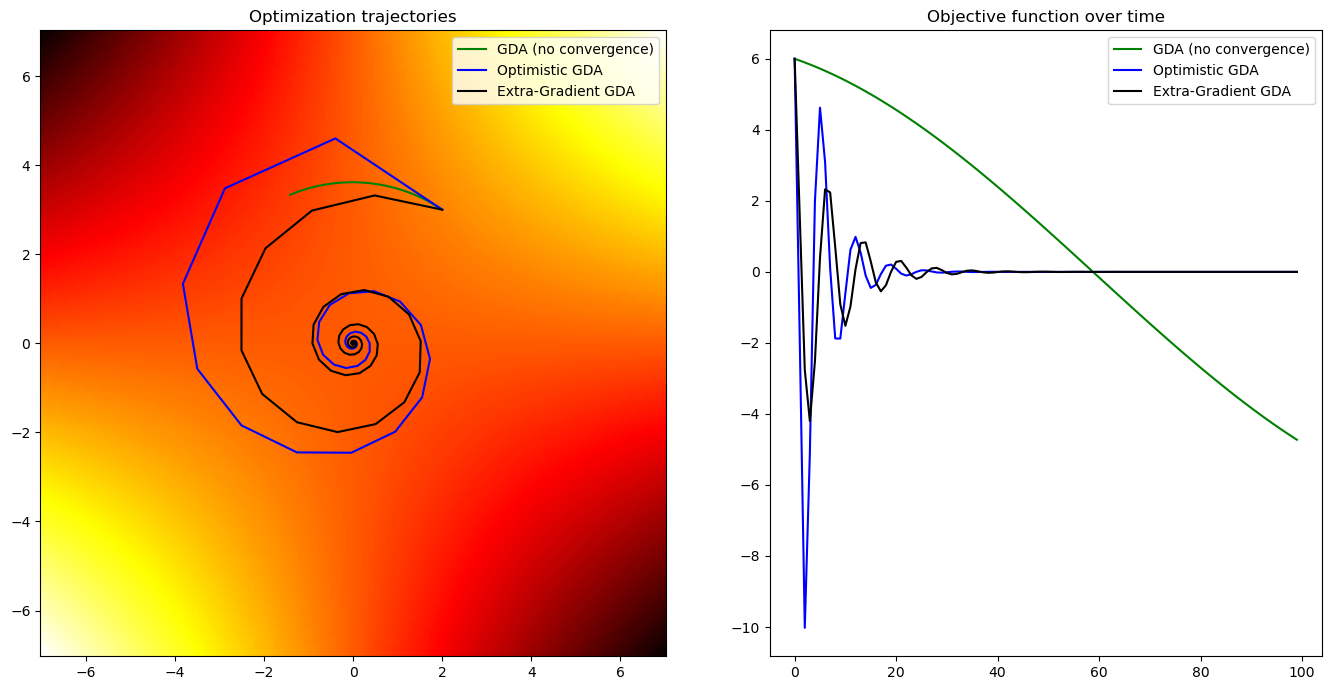

In [11]:
sz = 7
fig, ax = plt.subplots(1,2, figsize=(2*sz,sz)); plot_scalar_field(ax[0],simple_2d_objective,lims=[-7,7,-7,7]); 

x = 2.; y = 3.;
xs,ys,fs = GDA_solve(simple_2d_objective,x,y,100,0.01,1.)
ax[0].plot(xs,ys,color='g')
ax[1].plot(fs, color='g') ; 

x = 2.; y = 3.;
xs,ys,fs = OGDA_solve(simple_2d_objective,x,y,100,0.4,1.)
ax[0].plot(xs,ys,color='b')
ax[1].plot(fs, color='b') ; 

x = 2.; y = 3.;
xs,ys,fs = EGDA_solve(simple_2d_objective,x,y,100,0.4,1.)
ax[0].plot(xs,ys,color='k')
ax[1].plot(fs,color='k') ;

ax[1].set_aspect(7); 

ax[0].set_title('Optimization trajectories')
ax[0].legend(['GDA (no convergence)','Optimistic GDA','Extra-Gradient GDA'])
ax[1].legend(['GDA (no convergence)','Optimistic GDA','Extra-Gradient GDA'])
ax[1].set_title('Objective function over time')
fig.tight_layout(); plt.show() # plot the function